/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3045341/2782204172.py:154: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) 

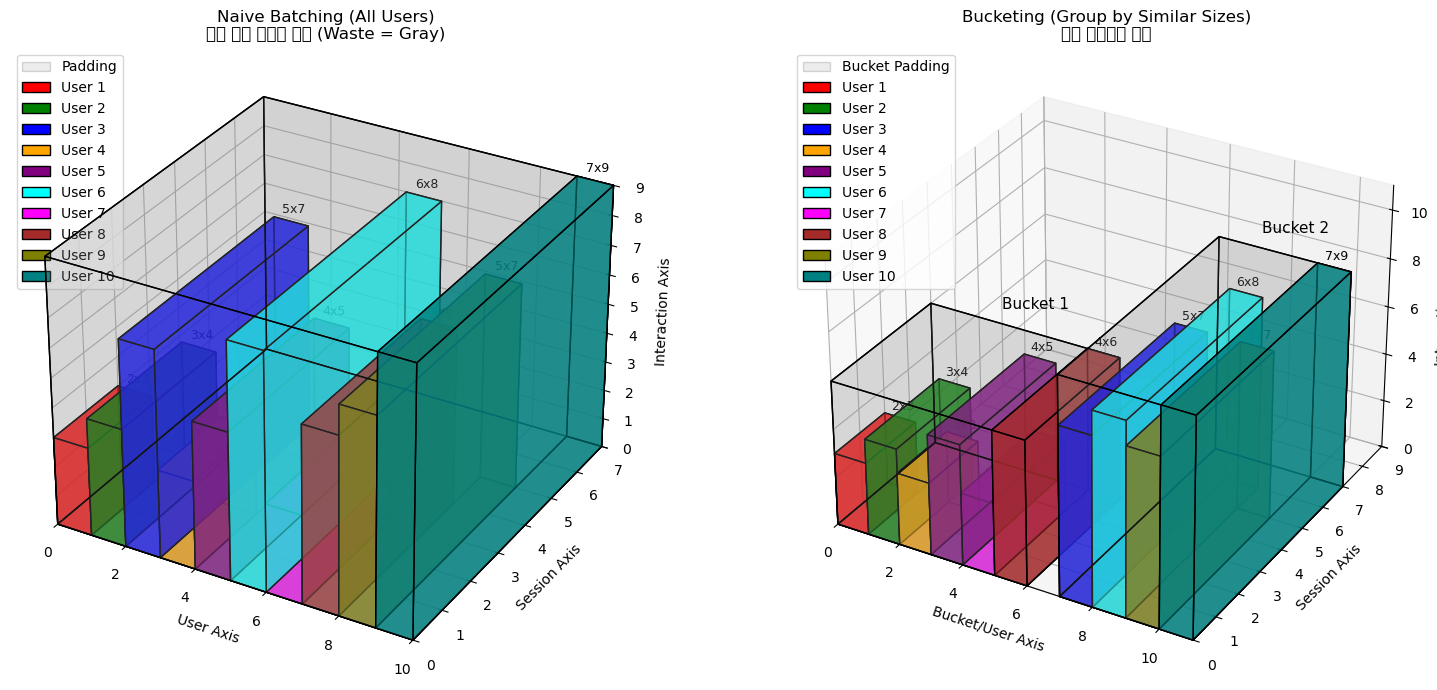

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch

# 3D Cuboid 그리기 위한 헬퍼 함수
def plot_cuboid(ax, origin, size, color='gray', alpha=0.3, edgecolor='black'):
    """
    origin: (x, y, z) 시작점 (왼쪽 아래 앞)
    size: (dx, dy, dz) 폭, 세션 수, 길이
    """
    x0, y0, z0 = origin
    dx, dy, dz = size
    # 8개 꼭짓점 계산
    vertices = np.array([
        [x0, y0, z0],
        [x0+dx, y0, z0],
        [x0+dx, y0+dy, z0],
        [x0, y0+dy, z0],
        [x0, y0, z0+dz],
        [x0+dx, y0, z0+dz],
        [x0+dx, y0+dy, z0+dz],
        [x0, y0+dy, z0+dz]
    ])
    faces = [
        [vertices[j] for j in [0,1,2,3]],  # 밑면
        [vertices[j] for j in [4,5,6,7]],  # 윗면
        [vertices[j] for j in [0,1,5,4]],  # 앞면
        [vertices[j] for j in [2,3,7,6]],  # 뒷면
        [vertices[j] for j in [1,2,6,5]],  # 오른쪽
        [vertices[j] for j in [0,3,7,4]]   # 왼쪽
    ]
    poly3d = Poly3DCollection(faces, facecolors=color, edgecolors=edgecolor, alpha=alpha)
    ax.add_collection3d(poly3d)

# 사용자 데이터: (세션 수, max_interaction)
# 10명의 사용자를 가정
user_data = [
    (2, 3),
    (3, 4),
    (5, 7),
    (2, 3),
    (4, 5),
    (6, 8),
    (3, 3),
    (4, 6),
    (5, 7),
    (7, 9)
]
# 사용자별 색상 (Naive plot에서는 순서대로 할당)
user_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'olive', 'teal']

# Naive 방식: 전체 사용자 배치 시 전체 최대값으로 패딩
n_users = len(user_data)
max_sessions = max(sess for sess, _ in user_data)
max_interaction = max(seq for _, seq in user_data)

fig = plt.figure(figsize=(16, 7))

#################################
# (1) Naive 3D Padding: 모든 사용자를 하나의 배치로 패딩
#################################
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Naive Batching (All Users)\n전체 최대 크기로 패딩 (Waste = Gray)")
ax1.set_xlabel("User Axis")
ax1.set_ylabel("Session Axis")
ax1.set_zlabel("Interaction Axis")

# 전체 배치의 회색 패딩 블록: 크기 (n_users, max_sessions, max_interaction)
plot_cuboid(ax1, origin=(0, 0, 0), size=(n_users, max_sessions, max_interaction),
            color='gray', alpha=0.15, edgecolor='black')

# 각 사용자의 실제 데이터 블록 (패딩 영역보다 작음)
for i, (sess, seq) in enumerate(user_data):
    # x축: 사용자 i부터 i+1
    # 실제 데이터 블록: 크기 (1, sess, seq)
    plot_cuboid(ax1, origin=(i, 0, 0), size=(1, sess, seq),
                color=user_colors[i], alpha=0.6, edgecolor='black')
    # 텍스트로 실제 크기 표시
    ax1.text(i+0.5, sess+0.1, seq+0.1, f"{sess}x{seq}", ha='center', va='bottom', fontsize=9)

ax1.set_xlim(0, n_users)
ax1.set_ylim(0, max_sessions)
ax1.set_zlim(0, max_interaction)
legend_elements1 = [Patch(facecolor='gray', edgecolor='black', alpha=0.15, label='Padding')]
for i, c in enumerate(user_colors):
    legend_elements1.append(Patch(facecolor=c, edgecolor='black', label=f'User {i+1}'))
ax1.legend(handles=legend_elements1, loc='upper left')

#################################
# (2) Bucketing: 유사한 크기의 사용자끼리 그룹핑하여 최소 패딩
#################################
# 예시로 두 버킷으로 그룹화: 
# Bucket 1: 세션 수가 4 이하인 사용자, Bucket 2: 세션 수가 5 이상인 사용자
bucket1 = [(i, ud) for i, ud in enumerate(user_data) if ud[0] <= 4]
bucket2 = [(i, ud) for i, ud in enumerate(user_data) if ud[0] > 4]

# 각 버킷별 최대값 계산
if bucket1:
    bucket1_max_sess = max(ud[0] for _, ud in bucket1)
    bucket1_max_seq  = max(ud[1] for _, ud in bucket1)
else:
    bucket1_max_sess, bucket1_max_seq = 0, 0
if bucket2:
    bucket2_max_sess = max(ud[0] for _, ud in bucket2)
    bucket2_max_seq  = max(ud[1] for _, ud in bucket2)
else:
    bucket2_max_sess, bucket2_max_seq = 0, 0

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Bucketing (Group by Similar Sizes)\n최소 패딩으로 배치")
ax2.set_xlabel("Bucket/User Axis")
ax2.set_ylabel("Session Axis")
ax2.set_zlabel("Interaction Axis")

# 버킷별로 x축 위치를 다르게 배정
x_offset = 0

# 버킷 1 그리기
if bucket1:
    n_bucket1 = len(bucket1)
    # 버킷 전체를 감싸는 회색 블록 (패딩 최소)
    plot_cuboid(ax2, origin=(x_offset, 0, 0), size=(n_bucket1, bucket1_max_sess, bucket1_max_seq),
                color='gray', alpha=0.15, edgecolor='black')
    for j, (i, (sess, seq)) in enumerate(bucket1):
        plot_cuboid(ax2, origin=(x_offset+j, 0, 0), size=(1, sess, seq),
                    color=user_colors[i], alpha=0.6, edgecolor='black')
        ax2.text(x_offset+j+0.5, sess+0.1, seq+0.1, f"{sess}x{seq}", ha='center', va='bottom', fontsize=9)
    # 버킷 레이블
    ax2.text(x_offset + n_bucket1/2, bucket1_max_sess+0.5, bucket1_max_seq+0.5, "Bucket 1", ha='center', fontsize=11)
    x_offset += n_bucket1 + 1  # 다음 버킷 간 간격

# 버킷 2 그리기
if bucket2:
    n_bucket2 = len(bucket2)
    plot_cuboid(ax2, origin=(x_offset, 0, 0), size=(n_bucket2, bucket2_max_sess, bucket2_max_seq),
                color='gray', alpha=0.15, edgecolor='black')
    for j, (i, (sess, seq)) in enumerate(bucket2):
        plot_cuboid(ax2, origin=(x_offset+j, 0, 0), size=(1, sess, seq),
                    color=user_colors[i], alpha=0.6, edgecolor='black')
        ax2.text(x_offset+j+0.5, sess+0.1, seq+0.1, f"{sess}x{seq}", ha='center', va='bottom', fontsize=9)
    ax2.text(x_offset + n_bucket2/2, bucket2_max_sess+0.5, bucket2_max_seq+0.5, "Bucket 2", ha='center', fontsize=11)

# 축 범위 설정 (대략)
ax2.set_xlim(0, x_offset + (n_bucket2 if bucket2 else 0))
ax2.set_ylim(0, max(bucket1_max_sess if bucket1 else 0, bucket2_max_sess if bucket2 else 0) + 2)
ax2.set_zlim(0, max(bucket1_max_seq if bucket1 else 0, bucket2_max_seq if bucket2 else 0) + 2)

legend_elements2 = [Patch(facecolor='gray', edgecolor='black', alpha=0.15, label='Bucket Padding')]
for i, c in enumerate(user_colors):
    legend_elements2.append(Patch(facecolor=c, edgecolor='black', label=f'User {i+1}'))
ax2.legend(handles=legend_elements2, loc='upper left')

plt.tight_layout()
plt.show()
